In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt

In [2]:
SHORE_SIZE = 2000
SHELF_SIZE = 2000
CHROMOSOMES_SIZES ={
"chr1":	249250621,
"chr2":	243199373,
"chr3":	198022430,
"chr4":	191154276,
"chr5":	180915260,
"chr6":	171115067,
"chr7":	159138663,
"chr8":	146364022,
"chr9":	141213431,
"chr10":	135534747,
"chr11":	135006516,
"chr12":	133851895,
"chr13":	115169878,
"chr14":	107349540,
"chr15":	102531392,
"chr16":	90354753,
"chr17":	81195210,
"chr18":	78077248,
"chr20":	63025520,
"chr19":	59128983,
"chr22":	51304566,
"chr21":	48129895}
ALLOWED_CHROMOSOMES=CHROMOSOMES_SIZES.keys()

In [3]:
class BedEntry:
    def __init__(self,bedEntryType="",chromosome="",start=0,end=0):
        self.bedEntryType = bedEntryType
        self.chromosome = chromosome
        self.start = start
        self.end = end

In [4]:
def loadBedFile(name, idColumn):
    output = []
    if idColumn:
        offset=1
    else:
        offset=0

    f = open(name, "r")
    while True:
        line = f.readline()
        if not line:
            break
        symbols = line.split("\t")
        row = BedEntry()
        row.chromosome = symbols[offset]
        row.start = int(symbols[offset+1])
        row.end = int(symbols[offset+2])
        row.bedEntryType = "CPG"
        output.append(row)
    return output

In [5]:
def processStart(firstCpg):
    result = []
    if firstCpg.start == 0:
        return

    shore = BedEntry()
    shore.chromosome = firstCpg.chromosome
    shore.start = firstCpg.start - SHORE_SIZE if (firstCpg.start - SHORE_SIZE > 0) else 0
    shore.end = firstCpg.start
    shore.bedEntryType = "SHORE"
    result.append(shore)

    if firstCpg.start > SHORE_SIZE:
        shelf = BedEntry()
        shelf.chromosome = firstCpg.chromosome
        shelf.start = firstCpg.start - SHORE_SIZE - SHELF_SIZE if (firstCpg.start - SHORE_SIZE - SHELF_SIZE > 0) else 0
        shelf.end = firstCpg.start - SHORE_SIZE
        shelf.bedEntryType = "SHELF"
        result.append(shelf)

    if firstCpg.start > SHORE_SIZE + SHELF_SIZE:
        sea = BedEntry()
        sea.chromosome = firstCpg.chromosome
        sea.start = 0
        sea.end = firstCpg.start - SHORE_SIZE - SHELF_SIZE
        sea.bedEntryType = "SEA"
        result.append(sea)

    return result

In [6]:
def processPair(firstCpg, secondCpg):
    result = []
    distance =  secondCpg.start - firstCpg.end

    #single shore
    if distance < (SHORE_SIZE*2):
        shore = BedEntry()
        shore.chromosome = firstCpg.chromosome
        shore.start = firstCpg.end
        shore.end = secondCpg.start
        shore.bedEntryType = "SHORE"
        result.append(shore)
        return result

    #add two shores
    startL = firstCpg.end
    endL = firstCpg.end+SHORE_SIZE
    result.append(BedEntry("SHORE",firstCpg.chromosome, startL,endL))
    startR = secondCpg.start-SHORE_SIZE
    endR = secondCpg.start
    result.append(BedEntry("SHORE",firstCpg.chromosome, startR,endR))

    #single shelf
    if distance< (SHELF_SIZE+SHORE_SIZE)*2:
        shelf = BedEntry()
        shelf.chromosome = firstCpg.chromosome
        shelf.start = firstCpg.end+SHORE_SIZE
        shelf.end = secondCpg.start-SHORE_SIZE
        shelf.bedEntryType = "SHELF"
        result.append(shelf)
        return result

    #add two shelfs
    startL = firstCpg.end+SHORE_SIZE
    endL = firstCpg.end+SHORE_SIZE+SHELF_SIZE
    result.append(BedEntry("SHELF",firstCpg.chromosome, startL,endL))
    startR = secondCpg.start-SHORE_SIZE-SHELF_SIZE
    endR = secondCpg.start-SHORE_SIZE
    result.append(BedEntry("SHELF",firstCpg.chromosome, startR,endR))

    #add sea
    sea = BedEntry()
    sea.chromosome = firstCpg.chromosome
    sea.start = firstCpg.end+SHORE_SIZE+SHELF_SIZE
    sea.end = secondCpg.start-SHORE_SIZE-SHELF_SIZE
    sea.bedEntryType = "SEA"
    result.append(sea)
    return result

In [7]:
def processEnd(lastCpg):
    chromosomeEnd = CHROMOSOMES_SIZES[lastCpg.chromosome]
    distanceToEnd = chromosomeEnd- lastCpg.end
    result = []
    if lastCpg.end == chromosomeEnd:
        return

    shore = BedEntry()
    shore.chromosome = lastCpg.chromosome
    shore.start = lastCpg.end
    shore.end = lastCpg.end + SHORE_SIZE if lastCpg.end + SHORE_SIZE < chromosomeEnd else chromosomeEnd
    shore.bedEntryType = "SHORE"
    result.append(shore)

    if distanceToEnd > SHORE_SIZE:
        shelf = BedEntry()
        shelf.chromosome = lastCpg.chromosome
        shelf.start = lastCpg.end + SHORE_SIZE
        shelf.end = lastCpg.end + SHORE_SIZE + SHELF_SIZE if lastCpg.end + SHORE_SIZE + SHELF_SIZE < chromosomeEnd else chromosomeEnd
        shelf.bedEntryType = "SHELF"
        result.append(shelf)

    if distanceToEnd > SHORE_SIZE + SHELF_SIZE:
        sea = BedEntry()
        sea.chromosome = lastCpg.chromosome
        sea.start = lastCpg.end + SHORE_SIZE + SHELF_SIZE
        sea.end = chromosomeEnd
        sea.bedEntryType = "SEA"
        result.append(sea)

    return result

In [8]:
def processChromosome(bedEntries):
    result = []
    result += processStart(bedEntries[0])
    for i in range(0, len(bedEntries)-2):
        result += processPair(bedEntries[i], bedEntries[i+1])
    result += processEnd(bedEntries[len(bedEntries)-1])
    result += bedEntries
    return result

In [9]:
def getMethylationData(regions, methylations):
    scores = {
        "CPG":0,
        "SHORE":0,
        "SHELF":0,
        "SEA":0
    }
    methylations.sort()
    regions.sort(key=lambda x: x.start)
    
    r=0
    for point in methylations:
        if regions[r].start <= point and point < regions[r].end:
            scores[regions[r].bedEntryType]+=1
        else:
            r+=1

        if r>len(regions)-1:
            break
    
    print(scores)
    scoreSum = sum(scores.values())
    labels=[]
    for k,v in scores.items():
        labels.append("{}: {} ({}%)".format(k,v, round(v/scoreSum*100,2)))

    plt.pie(scores.values(),labels=labels)
    plt.title(chromosome)
    plt.show()

    return scores

In [10]:
def saveToFiles(data):
    cpgFile = open("cpg.bed", "w")
    shoreFile = open("shore.bed", "w")
    shelfFile = open("shelf.bed", "w")
    seaFile = open("sea.bed", "w")

    for results in data.values():
        for row in results:
            if row.bedEntryType == "SHORE":
                shoreFile.write(f"{row.chromosome}\t{row.start}\t{row.end}\n")
            elif row.bedEntryType == "SHELF":
                shoreFile.write(f"{row.chromosome}\t{row.start}\t{row.end}\n")
            elif row.bedEntryType == "SEA":
                shoreFile.write(f"{row.chromosome}\t{row.start}\t{row.end}\n")
            elif row.bedEntryType == "CPG":
                shoreFile.write(f"{row.chromosome}\t{row.start}\t{row.end}\n")

{'CPG': 10200, 'SHORE': 7529, 'SHELF': 993, 'SEA': 14995}


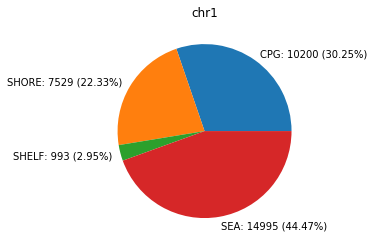

{'CPG': 7067, 'SHORE': 4871, 'SHELF': 483, 'SEA': 13267}


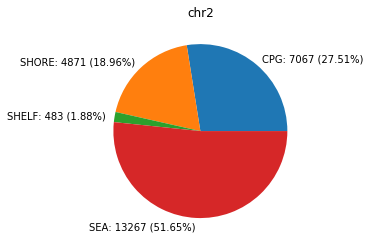

{'CPG': 5313, 'SHORE': 3596, 'SHELF': 251, 'SEA': 9493}


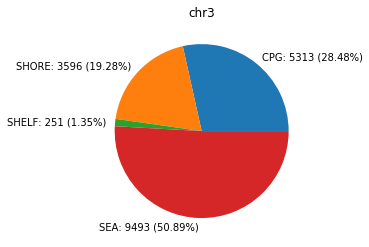

{'CPG': 4120, 'SHORE': 3063, 'SHELF': 354, 'SEA': 7539}


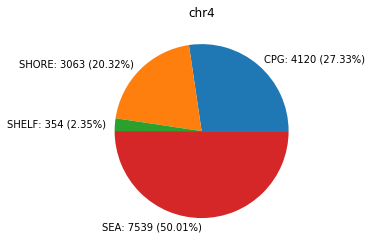

{'CPG': 5054, 'SHORE': 3861, 'SHELF': 384, 'SEA': 8702}


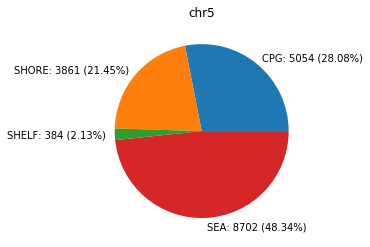

{'CPG': 7083, 'SHORE': 6897, 'SHELF': 1811, 'SEA': 14107}


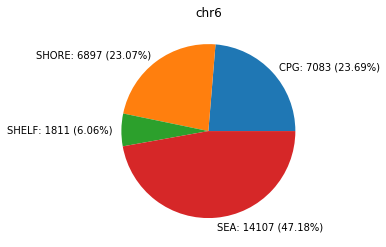

{'CPG': 5717, 'SHORE': 4916, 'SHELF': 972, 'SEA': 10399}


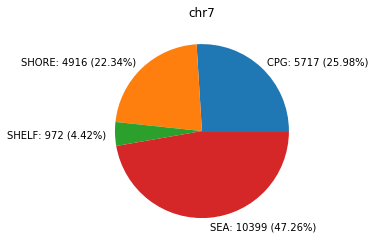

{'CPG': 3961, 'SHORE': 2993, 'SHELF': 424, 'SEA': 8135}


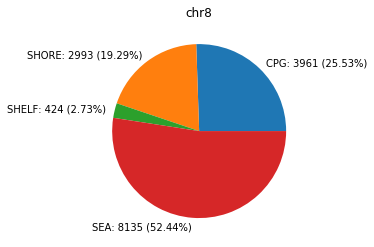

{'CPG': 1177, 'SHORE': 874, 'SHELF': 63, 'SEA': 1357}


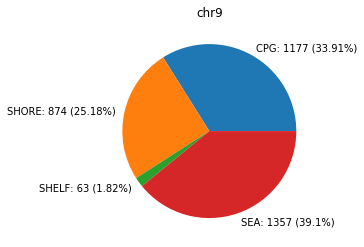

{'CPG': 4976, 'SHORE': 3450, 'SHELF': 603, 'SEA': 9242}


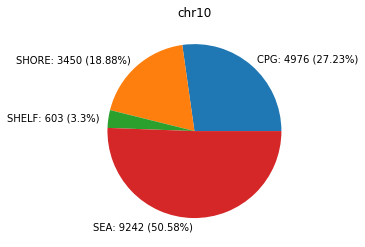

{'CPG': 6052, 'SHORE': 4528, 'SHELF': 789, 'SEA': 10277}


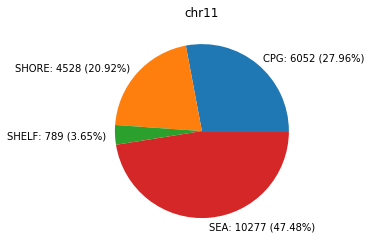

{'CPG': 4736, 'SHORE': 3987, 'SHELF': 551, 'SEA': 8813}


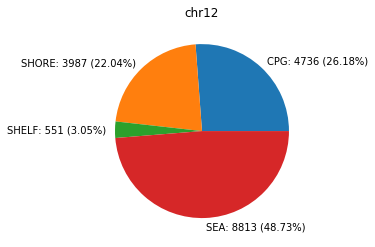

{'CPG': 2176, 'SHORE': 1831, 'SHELF': 348, 'SEA': 4789}


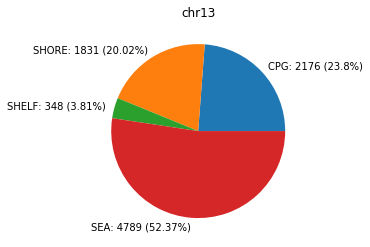

{'CPG': 3119, 'SHORE': 2111, 'SHELF': 284, 'SEA': 5322}


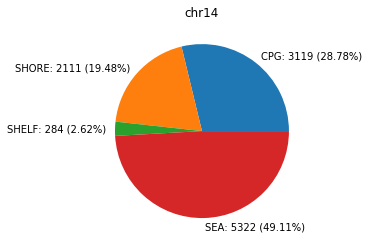

{'CPG': 3105, 'SHORE': 2002, 'SHELF': 170, 'SEA': 5537}


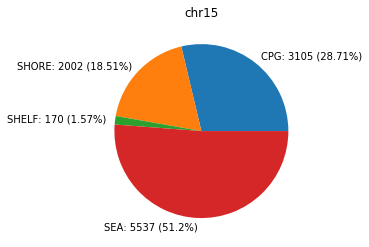

{'CPG': 4478, 'SHORE': 3534, 'SHELF': 812, 'SEA': 6106}


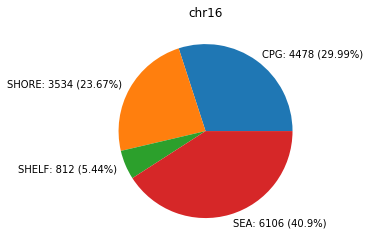

{'CPG': 6531, 'SHORE': 4469, 'SHELF': 995, 'SEA': 7682}


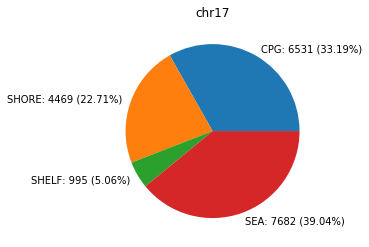

{'CPG': 1778, 'SHORE': 750, 'SHELF': 45, 'SEA': 657}


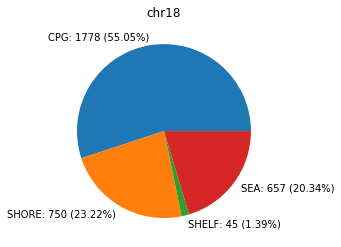

{'CPG': 2987, 'SHORE': 1688, 'SHELF': 181, 'SEA': 1474}


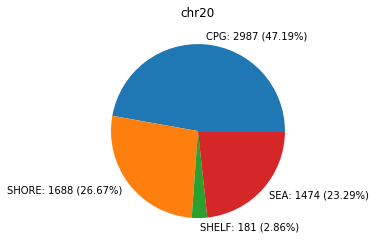

{'CPG': 7068, 'SHORE': 3917, 'SHELF': 512, 'SEA': 2733}


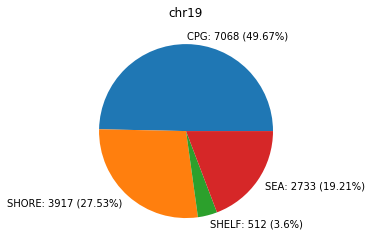

{'CPG': 2221, 'SHORE': 1183, 'SHELF': 120, 'SEA': 1192}


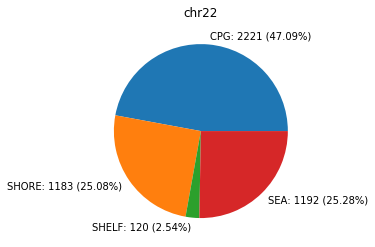

{'CPG': 1030, 'SHORE': 477, 'SHELF': 58, 'SEA': 786}


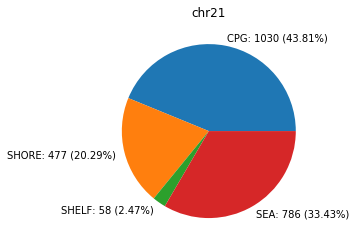

In [11]:
bedEntries = loadBedFile("resources/cpgIslandExt.txt",True )

bedEntriesDictionary = defaultdict(list)
for entry in bedEntries:
    if(entry.chromosome in ALLOWED_CHROMOSOMES):
        bedEntriesDictionary[entry.chromosome].append(entry)

results = defaultdict(list)
for chromosome in bedEntriesDictionary.keys():
    results[chromosome] = processChromosome(bedEntriesDictionary[chromosome])

saveToFiles(results)

mythylations = loadBedFile("resources/meythylations-hg19.bed", False)
mythylationsDictionary = defaultdict(list)
for entry in mythylations:
    if(entry.chromosome in ALLOWED_CHROMOSOMES):
        mythylationsDictionary[entry.chromosome].append((entry.start+entry.end)/2)

for chromosome in ALLOWED_CHROMOSOMES:
    scores = getMethylationData(results[chromosome],mythylationsDictionary[chromosome])